In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy.optimize import minimize

# --- Step 1: Data Collection and Ingestion ---

try:
    df = pd.read_csv('AmazonSaleReportOriginal.csv')
    print("Successfully loaded data.")
    print(df.head())
except FileNotFoundError:
    print("Error: 'AmazonSaleReportOriginal.csv' not found")

Successfully loaded data.
   index             Order ID      Date                        Status  \
0      0  405-8078784-5731545  04-30-22                     Cancelled   
1      1  171-9198151-1101146  04-30-22  Shipped - Delivered to Buyer   
2      2  404-0687676-7273146  04-30-22                       Shipped   
3      3  403-9615377-8133951  04-30-22                     Cancelled   
4      4  407-1069790-7240320  04-30-22                       Shipped   

  Fulfilment Sales Channel  ship-service-level    Style              SKU  \
0   Merchant      Amazon.in           Standard   SET389   SET389-KR-NP-S   
1   Merchant      Amazon.in           Standard  JNE3781  JNE3781-KR-XXXL   
2     Amazon      Amazon.in          Expedited  JNE3371    JNE3371-KR-XL   
3   Merchant      Amazon.in           Standard    J0341       J0341-DR-L   
4     Amazon      Amazon.in          Expedited  JNE3671  JNE3671-TU-XXXL   

        Category  ... currency  Amount    ship-city   ship-state  \
0         

C:\Users\Mr Nobody\AppData\Local\Temp\ipykernel_22760\3072424908.py:14: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('AmazonSaleReportOriginal.csv')


In [2]:
# --- Step 2: Data Cleaning and Preprocessing ---

# Drop the 'Unnamed: 22' column as it's entirely empty in the sample
if 'Unnamed: 22' in df.columns:
    df = df.drop(columns=['Unnamed: 22'])

# Handle missing values:
# For categorical columns, fill NaN with 'Unknown'
categorical_cols_to_fill = ['promotion-ids', 'Courier Status', 'fulfilled-by']
for col in categorical_cols_to_fill:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# For numerical columns like 'Amount' and 'Qty', drop rows with NaN as they are critical for analysis
df.dropna(subset=['Amount', 'Qty'], inplace=True)

# Convert 'Date' to datetime objects
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# Ensure 'Amount' and 'Qty' are numeric
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
df['Qty'] = pd.to_numeric(df['Qty'], errors='coerce')
df.dropna(subset=['Amount', 'Qty'], inplace=True)

# Feature Engineering:
# Extract time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Create a 'HasPromotion' binary feature
df['HasPromotion'] = df['promotion-ids'].apply(lambda x: 0 if x == 'Unknown' else 1)

print(df.info())
print(df.head())


C:\Users\Mr Nobody\AppData\Local\Temp\ipykernel_22760\1697195426.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
C:\Users\Mr Nobody\AppData\Local\Temp\ipykernel_22760\1697195426.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)


<class 'pandas.core.frame.DataFrame'>
Index: 121180 entries, 0 to 128974
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   index               121180 non-null  int64         
 1   Order ID            121180 non-null  object        
 2   Date                121180 non-null  datetime64[ns]
 3   Status              121180 non-null  object        
 4   Fulfilment          121180 non-null  object        
 5   Sales Channel       121180 non-null  object        
 6   ship-service-level  121180 non-null  object        
 7   Style               121180 non-null  object        
 8   SKU                 121180 non-null  object        
 9   Category            121180 non-null  object        
 10  Size                121180 non-null  object        
 11  ASIN                121180 non-null  object        
 12  Courier Status      121180 non-null  object        
 13  Qty                 121180 non-nul


Descriptive statistics for numerical columns:
              Amount            Qty
count  121180.000000  121180.000000
mean      648.561465       0.961231
std       281.211687       0.214354
min         0.000000       0.000000
25%       449.000000       1.000000
50%       605.000000       1.000000
75%       788.000000       1.000000
max      5584.000000       8.000000


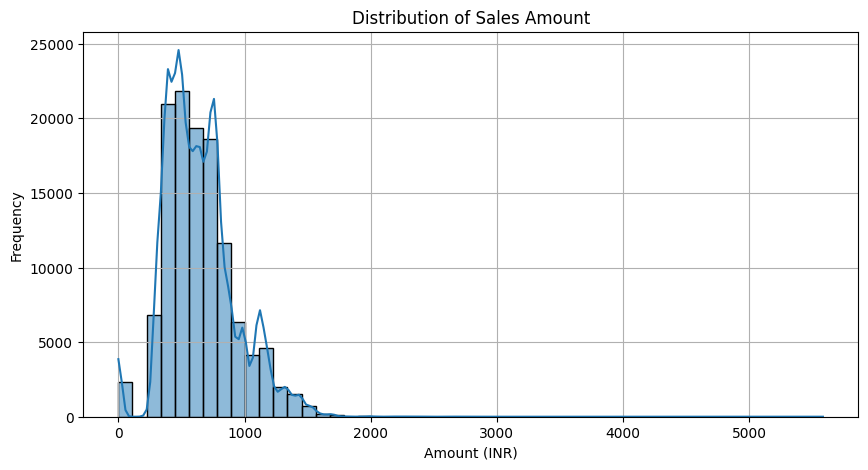

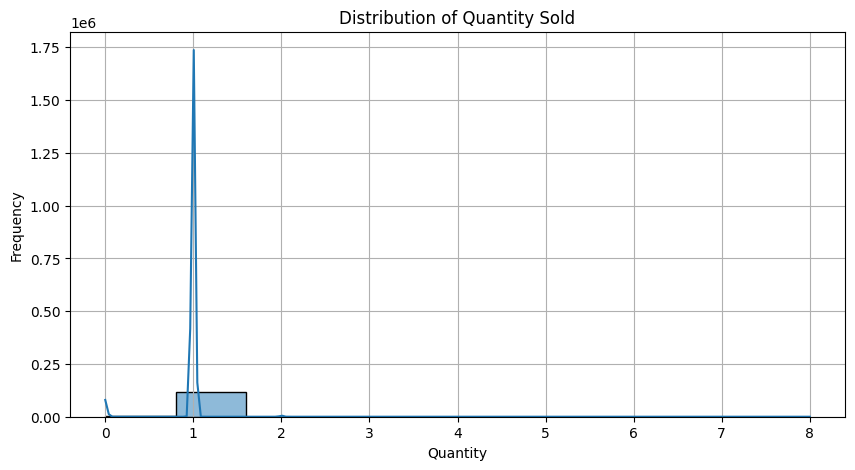

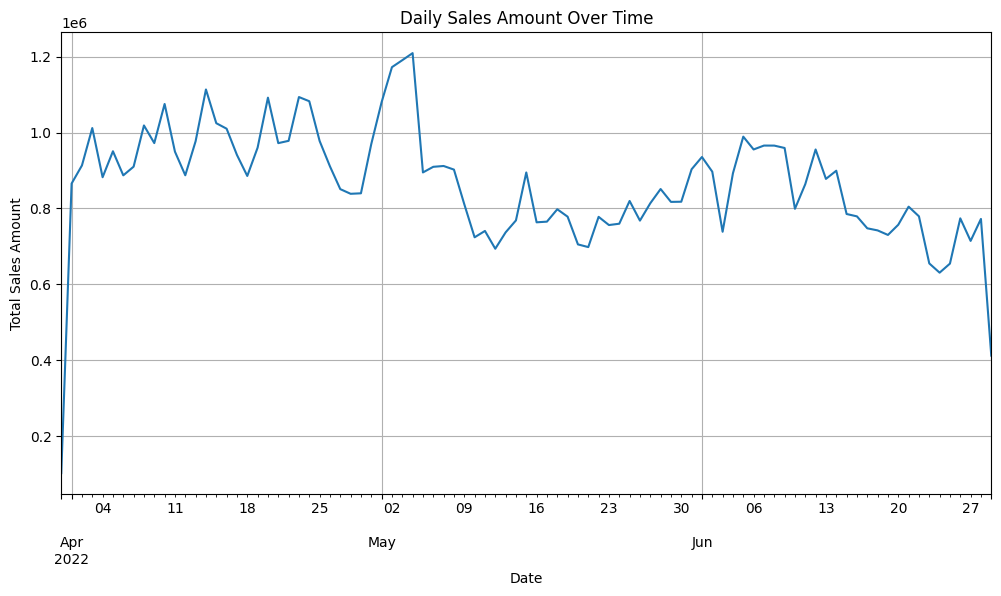

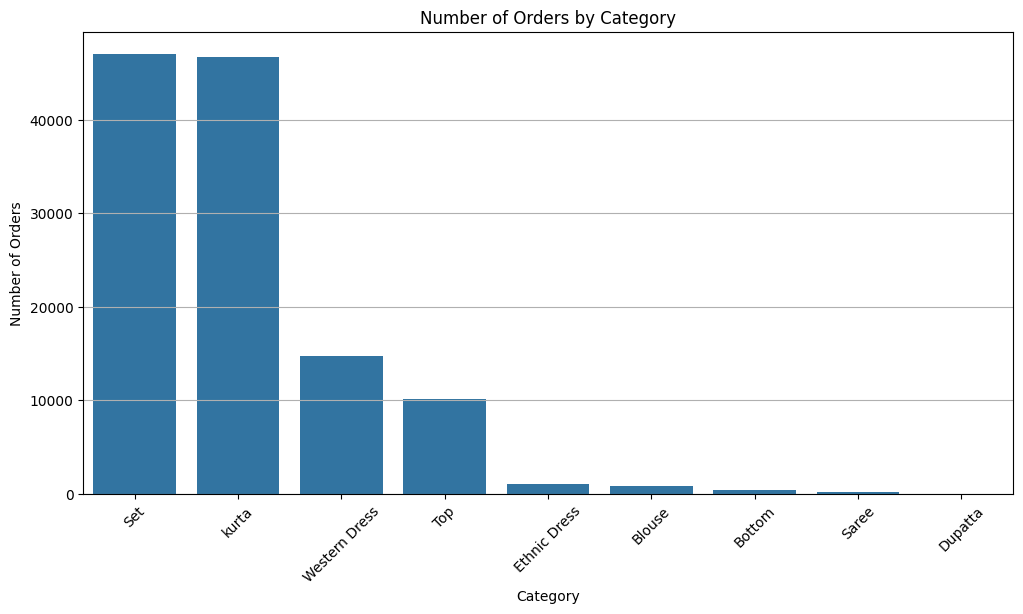

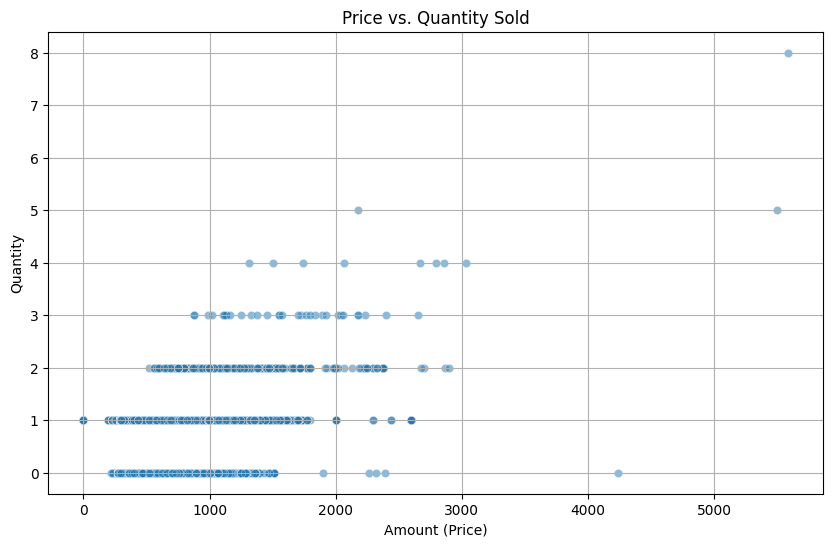

EDA plots generated. These should be more informative with the full dataset.


In [3]:
# --- Step 3: Exploratory Data Analysis (EDA) ---

# Basic descriptive statistics
print("\nDescriptive statistics for numerical columns:")
print(df[['Amount', 'Qty']].describe())

# Distribution of sales amount
plt.figure(figsize=(10, 5))
sns.histplot(df['Amount'], kde=True, bins=50)
plt.title('Distribution of Sales Amount')
plt.xlabel('Amount (INR)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Distribution of quantity sold
plt.figure(figsize=(10, 5))
sns.histplot(df['Qty'], kde=True, bins=10)
plt.title('Distribution of Quantity Sold')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Sales trends over time (now meaningful with full data)
plt.figure(figsize=(12, 6))
df.set_index('Date')['Amount'].resample('D').sum().plot()
plt.title('Daily Sales Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.grid(True)
plt.show()

# Sales by Category
plt.figure(figsize=(12, 6))
sns.barplot(x=df['Category'].value_counts().index, y=df['Category'].value_counts().values)
plt.title('Number of Orders by Category')
plt.xlabel('Category')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Relationship between Price (Amount) and Quantity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Amount', y='Qty', data=df, alpha=0.5)
plt.title('Price vs. Quantity Sold')
plt.xlabel('Amount (Price)')
plt.ylabel('Quantity')
plt.grid(True)
plt.show()
print("EDA plots generated. These should be more informative with the full dataset.")

In [4]:
# --- Step 4: Price Elasticity Modeling ---

# Price elasticity of demand (PED) = (% Change in Quantity Demanded) / (% Change in Price)
# For linear regression, PED = (slope * Price) / Quantity
# We'll use a log-log linear regression model for direct elasticity interpretation (coefficient is elasticity).

# Filter for 'Shipped' orders to analyze actual sales
sales_df = df[df['Status'] == 'Shipped'].copy()

if sales_df.empty:
    print("No 'Shipped' orders found in the filtered data. Cannot perform elasticity modeling.")
else:
    # Use log-log model for direct elasticity interpretation (coefficient is elasticity)
    # Add a small constant to avoid log(0) if Qty or Amount can be zero
    sales_df['log_Qty'] = np.log(sales_df['Qty'] + 1)
    sales_df['log_Amount'] = np.log(sales_df['Amount'] + 1)

    # --- IMPROVEMENT: Add more features for a better PED model ---
    # One-hot encode 'Category'
    sales_df = pd.get_dummies(sales_df, columns=['Category'], prefix='Category', drop_first=True)
    print("One-hot encoded 'Category' column.")

    # Define features (X) and target (y)
    # Include log_Amount, HasPromotion, DayOfWeek, Month, and one-hot encoded Category
    feature_cols = ['log_Amount', 'HasPromotion', 'DayOfWeek', 'Month']
    # Add all one-hot encoded category columns
    category_cols = [col for col in sales_df.columns if col.startswith('Category_')]
    feature_cols.extend(category_cols)

    # Ensure all feature columns exist before selecting
    existing_feature_cols = [col for col in feature_cols if col in sales_df.columns]
    X = sales_df[existing_feature_cols]
    y = sales_df['log_Qty']

    # --- FIX: Explicitly convert X and y to float and handle NaNs/Infs ---
    # Ensure all feature columns are numeric before adding constant and fitting model
    for col in existing_feature_cols:
        if X[col].dtype == 'object': # Check X directly, as it's the slice we're using
            print(f"Warning: Column '{col}' is still object type. Attempting to convert to numeric.")
            X[col] = pd.to_numeric(X[col], errors='coerce')

    # Convert X and y to float dtypes explicitly to prevent object issues with statsmodels
    X = X.astype(float)
    y = y.astype(float)

    # Combine X and y to drop NaNs consistently across both
    combined_df_for_model = pd.concat([X, y], axis=1).dropna()
    X = combined_df_for_model[X.columns]
    y = combined_df_for_model[y.name]

    # Check for Inf values and replace with NaN, then drop
    if np.isinf(X).any().any() or np.isinf(y).any():
        print("Warning: Inf values found in X or y after log transformation. Replacing with NaN and dropping rows.")
        X.replace([np.inf, -np.inf], np.nan, inplace=True)
        y.replace([np.inf, -np.inf], np.nan, inplace=True)
        # Drop NaNs again after replacing Infs
        combined_df_for_model = pd.concat([X, y], axis=1).dropna()
        X = combined_df_for_model[X.columns]
        y = combined_df_for_model[y.name]

    print(f"Data types of features (X) before OLS: {X.dtypes.to_dict()}")
    print(f"Data type of target (y) before OLS: {y.dtype}")

    # Add a constant to the independent variable for the intercept (required by statsmodels)
    X = sm.add_constant(X)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if len(X_train) < 2: # Need at least 2 points for regression
        print(f"Not enough data points ({len(X_train)} after split) to train a regression model for elasticity.")
    else:
        # Build and train the OLS (Ordinary Least Squares) regression model
        model = sm.OLS(y_train, X_train)
        results = model.fit()

        print("\nOLS Regression Results (Improved Price Elasticity Model):")
        print(results.summary())

        # The coefficient for log_Amount is the price elasticity of demand
        try:
            price_elasticity = results.params['log_Amount']
            print(f"\nEstimated Price Elasticity of Demand (PED): {price_elasticity:.2f}")

            if price_elasticity < -1:
                print("Interpretation: Demand is Elastic (a price increase will lead to a proportionally larger decrease in quantity demanded, thus decreasing total revenue).")
            elif price_elasticity >= -1 and price_elasticity < 0:
                print("Interpretation: Demand is Inelastic (a price increase will lead to a proportionally smaller decrease in quantity demanded, thus increasing total revenue).")
            elif price_elasticity == -1:
                print("Interpretation: Demand is Unit Elastic.")
            else:
                print("Interpretation: Positive elasticity, which is unusual for normal goods, might indicate a Giffen good, a luxury good, or data issues/confounding factors.")
        except KeyError:
            print("Could not find 'log_Amount' coefficient. Model might not have converged or data is too sparse.")
        except Exception as e:
            print(f"An error occurred during elasticity interpretation: {e}")

One-hot encoded 'Category' column.
Data types of features (X) before OLS: {'log_Amount': dtype('float64'), 'HasPromotion': dtype('float64'), 'Month': dtype('float64'), 'Category_Bottom': dtype('float64'), 'Category_Dupatta': dtype('float64'), 'Category_Ethnic Dress': dtype('float64'), 'Category_Saree': dtype('float64'), 'Category_Set': dtype('float64'), 'Category_Top': dtype('float64'), 'Category_Western Dress': dtype('float64'), 'Category_kurta': dtype('float64')}
Data type of target (y) before OLS: float64

OLS Regression Results (Improved Price Elasticity Model):
                            OLS Regression Results                            
Dep. Variable:                log_Qty   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     17.81
Date:                Tue, 22 Jul 2025   Prob (F-statistic):           6.14e-36
Time:                        00:


Simple Linear Regression Forecasting Results:
Mean Squared Error: 27690.46
R-squared: -0.00


C:\Users\Mr Nobody\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


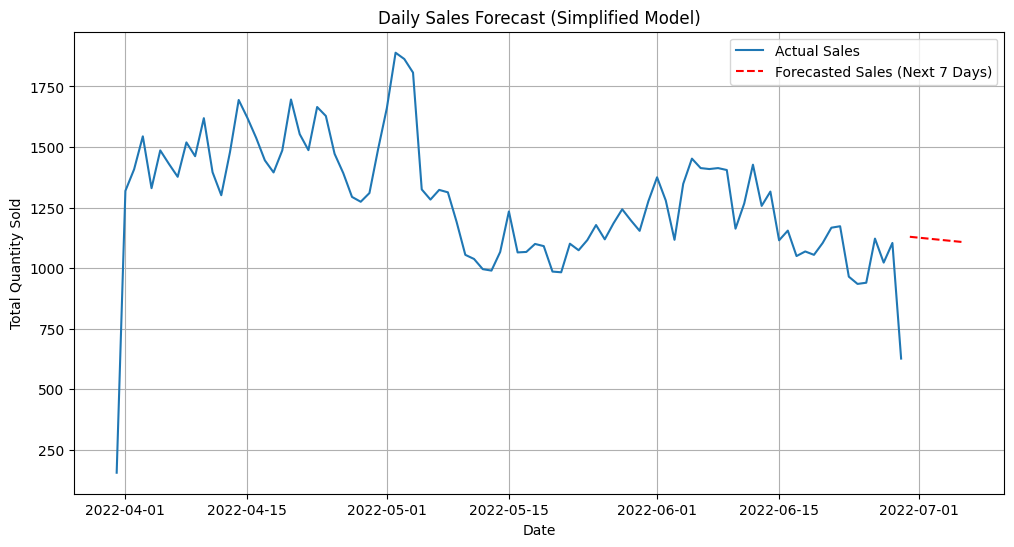


Forecast for the next 7 days (simplified model):
Date: 2022-06-30, Forecasted Qty: 1130
Date: 2022-07-01, Forecasted Qty: 1126
Date: 2022-07-02, Forecasted Qty: 1122
Date: 2022-07-03, Forecasted Qty: 1119
Date: 2022-07-04, Forecasted Qty: 1115
Date: 2022-07-05, Forecasted Qty: 1112
Date: 2022-07-06, Forecasted Qty: 1108

Note: For real-world demand forecasting, use dedicated time series models (ARIMA, Prophet, LSTM) and more features.


In [5]:
# --- Demand Forecasting ---
# For robust demand forecasting, a much larger time series dataset is needed.
# Here, we'll demonstrate a very simplified approach using linear regression over time,
# or a simple moving average, acknowledging its limitations.

# Aggregate sales data by date for forecasting
daily_sales = df.groupby('Date')['Qty'].sum().reset_index()
daily_sales.columns = ['Date', 'Total_Qty_Sold']
daily_sales = daily_sales.sort_values('Date')

if daily_sales.empty:
    print("No daily sales data available for forecasting.")
else:
    # Create a numerical representation of time
    daily_sales['Time_Index'] = (daily_sales['Date'] - daily_sales['Date'].min()).dt.days

    X_forecast = daily_sales[['Time_Index']]
    y_forecast = daily_sales['Total_Qty_Sold']

    # Split data for forecasting model (again, conceptual for small data)
    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_forecast, y_forecast, test_size=0.2, shuffle=False) # Keep time order

    if len(X_train_f) < 2:
        print(f"Not enough data points ({len(X_train_f)} after split) to train a forecasting model.")
    else:
        # Simple Linear Regression for forecasting (very basic, not a true time series model)
        forecasting_model = LinearRegression()
        forecasting_model.fit(X_train_f, y_train_f)

        # Make predictions
        y_pred_f = forecasting_model.predict(X_test_f)

        print("\nSimple Linear Regression Forecasting Results:")
        print(f"Mean Squared Error: {mean_squared_error(y_test_f, y_pred_f):.2f}")
        print(f"R-squared: {r2_score(y_test_f, y_pred_f):.2f}")

        # Plotting the forecast (conceptual for small data)
        plt.figure(figsize=(12, 6))
        plt.plot(daily_sales['Date'], daily_sales['Total_Qty_Sold'], label='Actual Sales')
        # Extend the time index for future prediction (e.g., next 7 days)
        last_time_index = daily_sales['Time_Index'].max()
        future_time_indices = np.array(range(last_time_index + 1, last_time_index + 8)).reshape(-1, 1)
        future_dates = [daily_sales['Date'].max() + pd.Timedelta(days=i) for i in range(1, 8)]

        future_predictions = forecasting_model.predict(future_time_indices)
        plt.plot(pd.to_datetime(future_dates), future_predictions, linestyle='--', color='red', label='Forecasted Sales (Next 7 Days)')

        plt.title('Daily Sales Forecast (Simplified Model)')
        plt.xlabel('Date')
        plt.ylabel('Total Quantity Sold')
        plt.legend()
        plt.grid(True)
        plt.show()

        print("\nForecast for the next 7 days (simplified model):")
        for i, date in enumerate(future_dates):
            print(f"Date: {date.strftime('%Y-%m-%d')}, Forecasted Qty: {max(0, round(future_predictions[i]))}")

        print("\nNote: For real-world demand forecasting, use dedicated time series models (ARIMA, Prophet, LSTM) and more features.")


In [6]:
# --- Step 6: Optimization and Strategy Recommendation ---
print("\nStep 6: Optimization and Strategy Recommendation")

# This step is highly conceptual without a full dataset and cost information.
# We'll define a hypothetical profit function and show how optimization would work.

# Assume a base cost per unit (e.g., 50% of the current average selling price)
# In a real scenario, COGS would be per SKU.
average_selling_price = df['Amount'].mean()
cost_per_unit = average_selling_price * 0.5 if not df.empty else 100 # Dummy cost if df is empty
print(f"Assumed average cost per unit: {cost_per_unit:.2f} INR")

if sales_df.empty or 'log_Amount' not in results.params:
    print("Cannot perform profit optimization without valid elasticity model results.")
else:
    # Get the estimated elasticity and intercept from the model
    # Ensure these are available from the previous step's successful model training
    try:
        elasticity_coefficient = results.params['log_Amount']
        intercept_coefficient = results.params['const']
    except KeyError:
        print("Elasticity model parameters not found. Skipping optimization.")
        elasticity_coefficient = -1.5 # Dummy value for demonstration
        intercept_coefficient = 5.0 # Dummy value for demonstration

    # Define a simplified demand function based on the log-log elasticity model
    # Q = exp(intercept + elasticity * log(P))
    # Where P is price, Q is quantity
    def demand_function(price, elasticity, intercept):
        # Add a small constant to price to avoid log(0)
        return np.exp(intercept + elasticity * np.log(price + 1e-6))

    # Define the profit function to maximize
    # Profit = (Price - Cost) * Quantity Demanded
    def profit_function(price, cost_per_unit, elasticity, intercept):
        if price <= cost_per_unit: # Price must be greater than cost for profit
            return -np.inf # Return negative infinity to discourage prices below cost
        quantity_demanded = demand_function(price, elasticity, intercept)
        profit = (price - cost_per_unit) * quantity_demanded
        return -profit # We want to maximize profit, so we minimize -profit

    # Initial guess for the optimal price (e.g., current average price)
    initial_price_guess = average_selling_price if not df.empty else 500

    # Define bounds for the price (e.g., price must be positive and within a reasonable range)
    # Lower bound should be above cost_per_unit to ensure profitability
    bounds = [(cost_per_unit * 1.05, initial_price_guess * 2)] # Price must be at least 5% above cost, up to double current avg

    print(f"\nAttempting to optimize profit with initial price guess: {initial_price_guess:.2f}")
    print(f"Price bounds for optimization: {bounds[0][0]:.2f} to {bounds[0][1]:.2f}")

    # Perform optimization using scipy's minimize function
    # 'L-BFGS-B' is a suitable algorithm for bounded optimization
    try:
        optimization_result = minimize(
            profit_function,
            x0=[initial_price_guess],
            args=(cost_per_unit, elasticity_coefficient, intercept_coefficient),
            method='L-BFGS-B',
            bounds=bounds
        )

        optimal_price = optimization_result.x[0]
        max_profit = -optimization_result.fun # Convert back from minimized negative profit

        print("\nOptimization Results:")
        print(f"Optimal Price: {optimal_price:.2f} INR")
        print(f"Estimated Max Profit at Optimal Price: {max_profit:.2f} INR")
        print(f"Estimated Quantity Demanded at Optimal Price: {demand_function(optimal_price, elasticity_coefficient, intercept_coefficient):.2f} units")

        print("\nStrategy Recommendation:")
        print(f"Based on the estimated price elasticity of {elasticity_coefficient:.2f} and forecasted demand,")
        print(f"the recommended optimal price for products (or the average product in this simplified model) is {optimal_price:.2f} INR.")
        print("This price aims to balance sales volume and profit margin to maximize overall profitability.")
        print("For a real system, this would be done per SKU, considering inventory, competitor prices, and real-time data.")

    except Exception as e:
        print(f"Error during optimization: {e}")
        print("This might be due to insufficient data for a stable elasticity model or inappropriate bounds.")

print("\n--- End of Script ---")


Step 6: Optimization and Strategy Recommendation
Assumed average cost per unit: 324.28 INR

Attempting to optimize profit with initial price guess: 648.56
Price bounds for optimization: 340.49 to 1297.12

Optimization Results:
Optimal Price: 1297.12 INR
Estimated Max Profit at Optimal Price: 1948.57 INR
Estimated Quantity Demanded at Optimal Price: 2.00 units

Strategy Recommendation:
Based on the estimated price elasticity of 0.00 and forecasted demand,
the recommended optimal price for products (or the average product in this simplified model) is 1297.12 INR.
This price aims to balance sales volume and profit margin to maximize overall profitability.
For a real system, this would be done per SKU, considering inventory, competitor prices, and real-time data.

--- End of Script ---
